# BP domain adaptation of pre-trained agents for modified CartPole environments

In [1]:
import os
from datetime import date

import numpy as np
import torch
import torch.optim as optim
import random
import gym
import matplotlib.pyplot as plt
from copy import deepcopy

from cartpole_stuff.src.utils import evaluate_policy, rstdp_train_cartpole, evaluate_BP_policy

import site
site.addsitedir('../src/')

from cartpole_stuff.src.dsnn import RSTDPNet
from backpropamine_DQN import BP_RNetwork, Standard_RNetwork

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [3]:
# Environment specific parameters
env_name = 'CartPole-v0'
max_reward = 200
max_steps = 200

n_evaluations = 100
rstdp_episodes = 250

In [4]:
# Create environments
original_env = gym.make(env_name)

# modified_env = gym.make(env_name)
# modified_env.unwrapped.length *= 1.1

/home/luuk/Desktop/testing/.venv/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
# SNN Hyperparameters
simulation_time = 8
alpha = 0.8
beta = 0.8
threshold = 0.5
weight_scale = 1
architecture = [4, 64, 64, 2]

In [6]:
# RSTDP Hyperparameters
tau = 5
tau_e = 10
C = 0.01
# A+/- are calculated from the pre-trained network weights

In [7]:
evaluation_seeds = np.load('cartpole_stuff/seeds/evaluation_seeds.npy')
rstdp_seeds = np.load('cartpole_stuff/seeds/rstdp_training_seeds.npy')

In [8]:
# Load pre-trained model weights
weights_0 = torch.load('Standard_DQRNN_training_1000eps/checkpoint_Standard_DQRNN_0.pt', map_location=torch.device(device))
weights_1 = torch.load('Standard_DQRNN_training_1000eps/checkpoint_Standard_DQRNN_1.pt', map_location=torch.device(device))
weights_2 = torch.load('Standard_DQRNN_training_1000eps/checkpoint_Standard_DQRNN_2.pt', map_location=torch.device(device))
weights_3 = torch.load('Standard_DQRNN_training_1000eps/checkpoint_Standard_DQRNN_3.pt', map_location=torch.device(device))
weights_4 = torch.load('Standard_DQRNN_training_1000eps/checkpoint_Standard_DQRNN_4.pt', map_location=torch.device(device))
weights = [weights_0, weights_1, weights_2, weights_3, weights_4]


In [9]:
# Helper for printing
eraser = '\b \b'

### Evaluate pre-trained BP models on original environment

In [10]:
original_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = Standard_RNetwork(4, 64, 2, 5).to(device)
    policy_net.loadWeights(w)

    rewards = evaluate_BP_policy(policy_net, original_env, n_evaluations, evaluation_seeds)
    original_eval_rewards.append(rewards)
    
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

print(f"Mean avg reward: {np.mean(original_eval_rewards)}")

Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  200.00
Run 03 -> Avg reward:  199.71
Run 04 -> Avg reward:  200.00
Mean avg reward: 199.942


### Evaluate pre-trained BP models on modified environments

In [11]:
percentages = np.linspace(1.1, 2.0, 10)
all_modified_env_eval_rewards = []
for percentage in percentages:

    modified_env = gym.make(env_name)
    modified_env.unwrapped.length *= percentage

    modified_env_eval_rewards = []

    for i, w in enumerate(weights):
        print('Run {:02d} ...'.format(i), end='')
        policy_net = Standard_RNetwork(4, 64, 2, 5).to(device)
        policy_net.loadWeights(w)

        rewards = evaluate_BP_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
        modified_env_eval_rewards.append(rewards)
        
        print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

    all_modified_env_eval_rewards.append(modified_env_eval_rewards)


/home/luuk/Desktop/testing/.venv/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:   78.48
Run 03 -> Avg reward:  199.69
Run 04 -> Avg reward:  200.00
Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:   31.71
Run 03 -> Avg reward:  199.91
Run 04 -> Avg reward:  200.00
Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:  192.64
Run 02 -> Avg reward:   24.73
Run 03 -> Avg reward:  199.86
Run 04 -> Avg reward:  200.00
Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:   61.95
Run 02 -> Avg reward:   20.55
Run 03 -> Avg reward:  199.85
Run 04 -> Avg reward:  200.00
Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:   59.42
Run 02 -> Avg reward:   15.81
Run 03 -> Avg reward:  199.88
Run 04 -> Avg reward:  200.00
Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:   57.50
Run 02 -> Avg reward:   13.14
Run 03 -> Avg reward:  199.80
Run 04 -> Avg reward:  200.00
Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:   56.99
Run 02 -> Avg reward:   12.80
Run 03 -> 

In [12]:
mean_avgs = []
std_dev_avgs = []
for results in all_modified_env_eval_rewards:
    mean_avgs.append(np.mean(results))
    std_dev_avgs.append(np.std(results))
    print(np.mean(results))

175.634
166.324
163.446
136.47
135.022
134.088
131.716
126.95
116.048
104.618


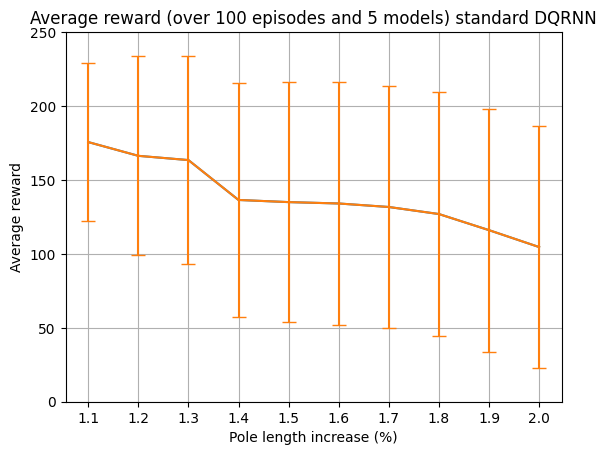

In [14]:
fig = plt.figure()
plt.plot(percentages, mean_avgs)
plt.errorbar(percentages, mean_avgs, std_dev_avgs, capsize=5)
plt.ylim(0, 250)
plt.grid(True)
plt.xlabel("Pole length increase (%)")
plt.xticks(percentages)
plt.ylabel("Average reward")
plt.title("Average reward (over 100 episodes and 5 models) standard DQRNN")
plt.savefig("figs/Standard_DQRNN_1000eps_5models_evaluation.png", dpi=300)

### BP fine tuning

In [14]:
# Hyperparameters
batch_size = 128
discount_factor = 0.999
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.999
update_every = 4
target_update_frequency = 100
learning_rate = 0.001 # lr is 0.0001 for simple maze as default
l2_coef = 0 # 0 is default in simple maze task
replay_memory_size = 4*10**4
tau = 1e-3

BP_finetuning_rewards = []
adapted_weights_collection = []

for i, w in enumerate(weights):
    
    policy_net = BP_RNetwork(4, 64, 2, 5).to(device)
    policy_net.loadWeights(w)
    target_net = BP_RNetwork(4, 64, 2, 5).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr = learning_rate, weight_decay = l2_coef) 
    agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau)




    
    adapted_weights, rewards = BP_fine_tuning(policy_net, modified_env, max_reward, rstdp_episodes, 
                                                 n_evaluations, max_steps, rstdp_seeds, evaluation_seeds)
    
    BP_finetuning_rewards.append(rewards)
    adapted_weights_collection.append(adapted_weights)
    
adapted_weights_collection = [(list(aw.values()), []) for aw in adapted_weights_collection]

KeyboardInterrupt: 

### Evaluate adapted models on modified environment

In [15]:
adapted_eval_rewards = []

for i, w in enumerate(adapted_weights_collection):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    adapted_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


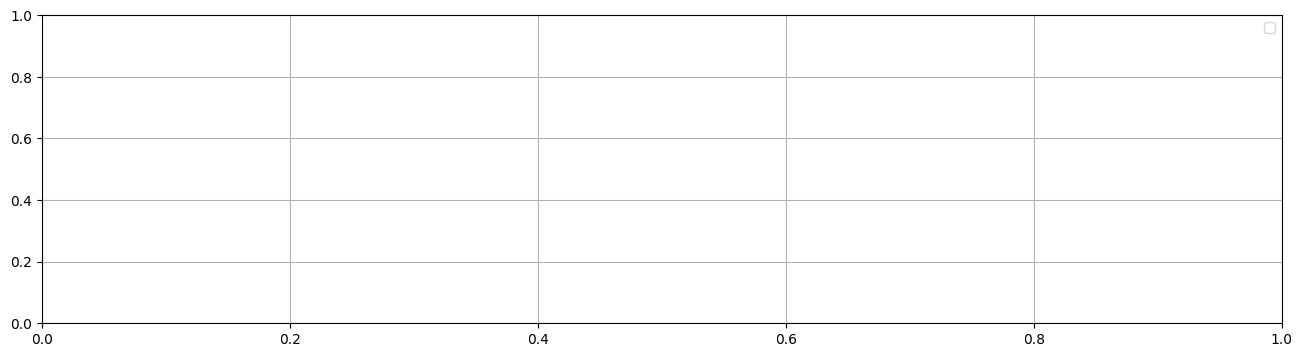

In [16]:
plt.figure(figsize=(16, 4))

for i, aer in enumerate(adapted_eval_rewards):
    plt.plot(aer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()